In [2]:
from IPython import get_ipython


def type_of_script():
    """
    Detects and returns the type of python kernel
    :return: string 'jupyter' or 'ipython' or 'terminal'
    """
    try:
        ipy_str = str(type(get_ipython()))
        if 'zmqshell' in ipy_str:
            return 'jupyter'
        if 'terminal' in ipy_str:
            return 'ipython'
    except:
        return 'terminal'


if type_of_script() == 'jupyter':
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm
    
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec

import numpy as np
import os, glob, atexit, signal
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=0
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
from importlib import reload
from copy import deepcopy
from multiprocessing import Pool, shared_memory, Value
from common_func import *

In [15]:
mode1 = 'nh'
database1 = f"/home/jeon/MissingSat/database/{mode1}"
iout1 = 1026
repo1, rurmode1, dp1 = mode2repo(mode1)
snap1 = uri.RamsesSnapshot(repo1, iout1, mode=rurmode1)
snap1s = uri.TimeSeries(snap1)
snap1s.read_iout_avail()
nout1 = snap1s.iout_avail['iout']; nout=nout1[nout1 <= iout1]
gals1 = uhmi.HaloMaker.load(snap1, galaxy=True, double_precision=dp1)
hals1 = uhmi.HaloMaker.load(snap1, galaxy=False, double_precision=dp1)

LG1 = pklload(f"{database1}/LocalGroup.pickle")
allsats1 = None; allsubs1 = None; states1 = None
keys1 = list(LG1.keys())
for key in keys1:
    sats = LG1[key]['sats']; subs = LG1[key]['subs']; real = LG1[key]['real']
    dink = real[real['state']=='dink']['hid']
    ind = isin(subs['id'], dink)
    subs['dink'][ind] = True; subs['dink'][~ind] = False
    state = np.zeros(len(subs), dtype='<U7')
    state[ind] = 'dink'; state[~ind] = 'pair'
    
    upair = real[real['state']=='upair']['hid']
    ind = isin(subs['id'], upair)
    state[ind] = 'upair'

    allsats1 = sats if allsats1 is None else np.hstack((allsats1, sats))
    allsubs1 = subs if allsubs1 is None else np.hstack((allsubs1, subs))
    states1 = state if states1 is None else np.hstack((states1, state))
argsort = np.argsort(allsubs1['id'])
allsubs1 = allsubs1[argsort]; states1 = states1[argsort]
dinks1 = allsubs1[states1 == 'dink']
pairs1 = allsubs1[states1 == 'pair']
upairs1 = allsubs1[states1 == 'upair']

print(len(allsubs1), np.unique(states1, return_counts=True))

1336 (array(['dink', 'pair', 'upair'], dtype='<U7'), array([1145,  130,   61]))


In [16]:
mode2 = 'nh2'
database2 = f"/home/jeon/MissingSat/database/{mode2}"
iout2 = 797
repo2, rurmode2, dp2 = mode2repo(mode2)
snap2 = uri.RamsesSnapshot(repo2, iout2, mode=rurmode2)
snap2s = uri.TimeSeries(snap2)
snap2s.read_iout_avail()
nout2 = snap2s.iout_avail['iout']; nout=nout2[nout2 <= iout2]
gals2 = uhmi.HaloMaker.load(snap2, galaxy=True, double_precision=dp2)
hals2 = uhmi.HaloMaker.load(snap2, galaxy=False, double_precision=dp2)

LG2 = pklload(f"{database2}/LocalGroup.pickle")
allsats2 = None; allsubs2 = None; states2 = None
keys2 = list(LG2.keys())
for key in keys2:
    sats = LG2[key]['sats']; subs = LG2[key]['subs']; real = LG2[key]['real']
    dink = real[real['state']=='dink']['hid']
    ind = isin(subs['id'], dink)
    subs['dink'][ind] = True; subs['dink'][~ind] = False
    state = np.zeros(len(subs), dtype='<U7')
    state[ind] = 'dink'; state[~ind] = 'pair'
    
    upair = real[real['state']=='upair']['hid']
    ind = isin(subs['id'], upair)
    state[ind] = 'upair'

    allsats2 = sats if allsats2 is None else np.hstack((allsats2, sats))
    allsubs2 = subs if allsubs2 is None else np.hstack((allsubs2, subs))
    states2 = state if states2 is None else np.hstack((states2, state))
argsort = np.argsort(allsubs2['id'])
allsubs2 = allsubs2[argsort]; states2 = states2[argsort]
dinks2 = allsubs2[states2 == 'dink']
pairs2 = allsubs2[states2 == 'pair']
upairs2 = allsubs2[states2 == 'upair']

print(len(allsubs2), np.unique(states2, return_counts=True))

1242 (array(['dink', 'pair', 'upair'], dtype='<U7'), array([1120,   79,   43]))


/tmp/ipykernel_20031/3136656460.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{int(y)}" for y in ytick])


Text(0, 0.5, 'N')

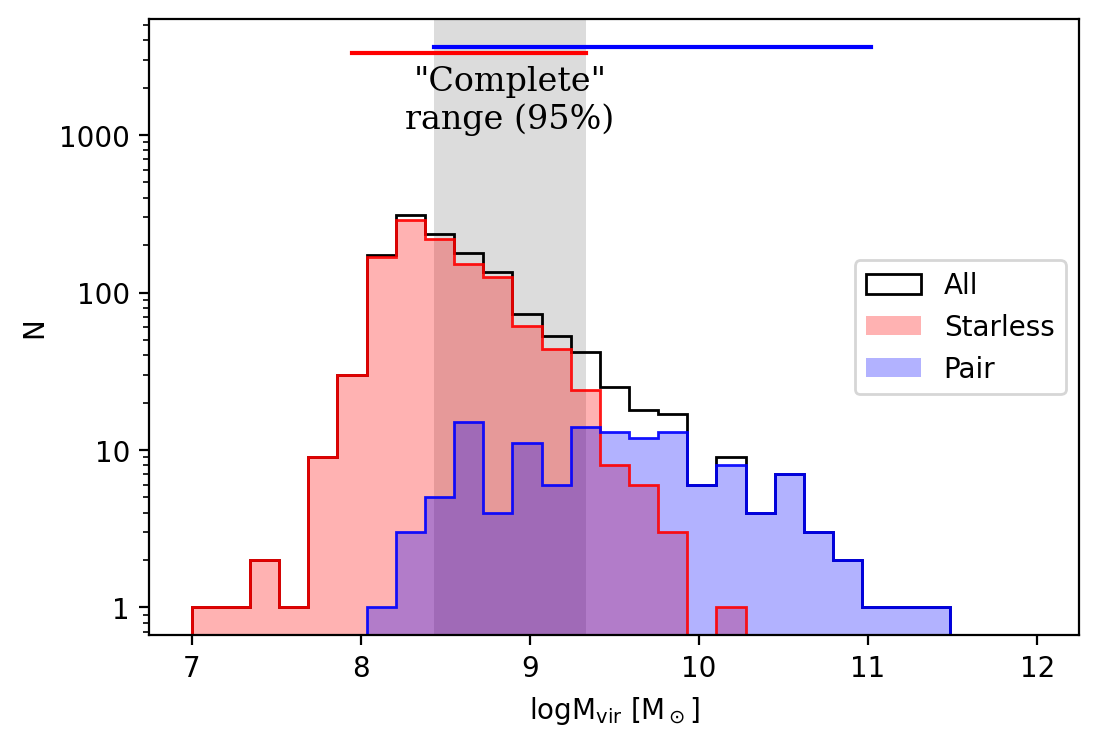

In [8]:
fig, ax = plt.subplots(ncols=1, figsize=(6,4), dpi=200)
plt.subplots_adjust(wspace=0)

mbins = np.linspace(7,12,30)
mleng = len(mbins)-1
xs = 0.5*(mbins[1:]+mbins[:-1])
colors = ['k', 'r', 'b', 'g']

m1d, m2d = np.nanpercentile(np.hstack((dinks1['mvir'],dinks2['mvir'])), q=[2.5,97.5])
m1p, m2p = np.nanpercentile(np.hstack((pairs1['mvir'],pairs2['mvir'])), q=[2.5,97.5])
m1 = np.max([m1d,m1p]); m2 = np.min([m2d,m2p])

colorcount = 0
ax.hist(np.log10(allsubs1['mvir']), bins=mbins, color=colors[colorcount],label='All', histtype='step'); colorcount+=1
ax.plot([np.log10(m1d), np.log10(m2d)], [3000*(1+colorcount/10),3000*(1+colorcount/10)], color=colors[colorcount])
ax.hist(np.log10(dinks1['mvir']), bins=mbins, color=colors[colorcount],label='Starless', histtype='stepfilled', alpha=0.3)
ax.hist(np.log10(dinks1['mvir']), bins=mbins, color=colors[colorcount], histtype='step', alpha=0.9); colorcount+=1
ax.plot([np.log10(m1p), np.log10(m2p)], [3000*(1+colorcount/10),3000*(1+colorcount/10)], color=colors[colorcount])
ax.hist(np.log10(pairs1['mvir']), bins=mbins, color=colors[colorcount],label='Pair', histtype='stepfilled', alpha=0.3)
ax.hist(np.log10(pairs1['mvir']), bins=mbins, color=colors[colorcount], histtype='step', alpha=0.9); colorcount+=1
ax.axvspan(np.log10(m1), np.log10(m2), ec='none', fc='gainsboro', zorder=-1)
ax.text((np.log10(m1)+np.log10(m2))/2, 1000, '"Complete"\nrange (95%)', ha='center', va='bottom', color='k', fontsize=12, family='serif')
ax.set_yscale('log')
ytick = ax.get_yticks()
ax.legend()
ax.set_yticklabels([f"{int(y)}" for y in ytick])
ax.set_xlabel(r'logM$_{\rm vir}$ [M$_\odot$]')
ax.set_ylabel(r'N')

  0%|          | 0/2265 [00:00<?, ?it/s]

/tmp/ipykernel_20031/1295480827.py:30: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(iarr[mass_name]), np.log10(iarr[f'mcell{mass_suffix}']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=lw, zorder=zorder)
/tmp/ipykernel_20031/1295480827.py:31: RuntimeWarning: divide by zero encountered in log10
  vmax = np.max([np.log10(iarr[f'mstar{mass_suffix}']), np.log10(iarr[f'mcell{mass_suffix}']), np.log10(iarr[f'mcold{mass_suffix}'])])
/tmp/ipykernel_20031/1295480827.py:35: RuntimeWarning: divide by zero encountered in log10
  vmin = max( np.min([np.log10(iarr[f'mstar{mass_suffix}']), np.log10(iarr[f'mcell{mass_suffix}'])]), 3 )


  0%|          | 0/209 [00:00<?, ?it/s]

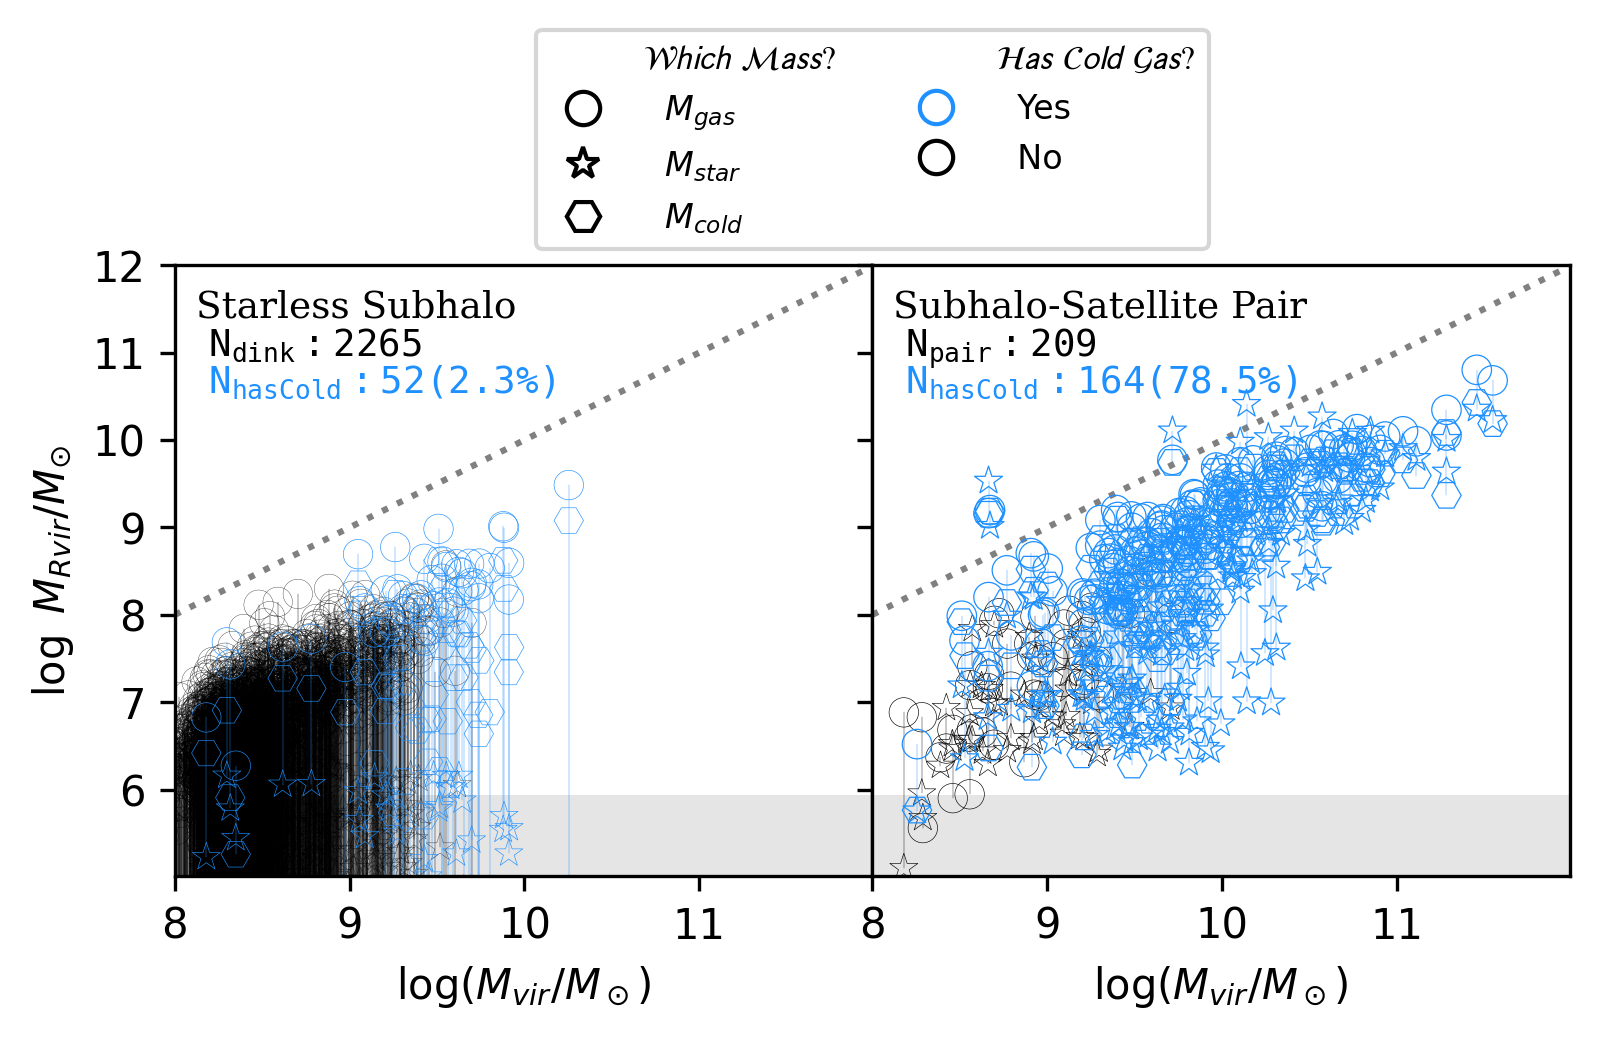

In [12]:
rname='Rvir'; mass_name='mvir'; xlabel='log($M_{vir}/M_\odot$)'
mass_suffix = "" if(mass_name=='mdm') else "_vir"
jump = False
if(not os.path.exists(f"03_components.png"))or(not jump):
    fig, axes = plt.subplots(ncols=2, dpi=300, figsize=(6,8), sharey=True)

    samples = [dinks1, pairs1, upairs1]
    samples2 = [dinks2, pairs2, upairs2]
    names = ["dink", "pair"]
    titles = ["Starless Subhalo", "Subhalo-Satellite Pair"]
    for i in range(2):
        ax = axes[i]
        sample = np.hstack((samples[i], samples2[i]))
        mask = sample[f'mcold{mass_suffix}'] < 1e3; sample[f'mcold{mass_suffix}'][mask] = 1e3
        mask = sample[f'mstar{mass_suffix}'] < 1e3; sample[f'mstar{mass_suffix}'][mask] = 1e3
        hascolds = sample[f'mcold{mass_suffix}']>1e3
        for iarr in tqdm(sample):
            hascold = iarr[f'mcold{mass_suffix}']>1e3
            color = 'k' if(not hascold) else 'dodgerblue'
            lw = 0.15 if(not hascold) else 0.3
            zorder = 0 if(not hascold) else 1
            facecolor='none'# if(isdink) else color
            edgecolor=color# if(isdink) else 'none' 
            linecolor=color
            if(i==0): lw/=2
            

            ax.scatter(np.log10(iarr[mass_name]), np.log10(iarr[f'mstar{mass_suffix}']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=lw, marker='*', zorder=zorder)
            if(iarr[f'mcold{mass_suffix}']>1e3): ax.scatter(np.log10(iarr[mass_name]), np.log10(iarr[f'mcold{mass_suffix}']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=lw, marker='H', zorder=zorder)
            ax.scatter(np.log10(iarr[mass_name]), np.log10(iarr[f'mcell{mass_suffix}']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=lw, zorder=zorder)
            vmax = np.max([np.log10(iarr[f'mstar{mass_suffix}']), np.log10(iarr[f'mcell{mass_suffix}']), np.log10(iarr[f'mcold{mass_suffix}'])])
            if(iarr[f'mcold{mass_suffix}']>1e3): 
                vmin = max( np.min([np.log10(iarr[f'mstar{mass_suffix}']), np.log10(iarr[f'mcell{mass_suffix}']), np.log10(iarr[f'mcold{mass_suffix}'])]), 3 )
            else:
                vmin = max( np.min([np.log10(iarr[f'mstar{mass_suffix}']), np.log10(iarr[f'mcell{mass_suffix}'])]), 3 )
            ax.plot([np.log10(iarr[mass_name]),np.log10(iarr[mass_name])], [vmin, vmax], color=linecolor, lw=0.1, zorder=zorder)

        ax.text(0.03, 0.96, f"{titles[i]}", ha='left', va='top', color='k', fontsize=9, transform=ax.transAxes, family='serif')
        ax.text(0.03, 0.90, fr"$\mathtt{{ \ N_{{{names[i]}}}: {len(sample)} }}$", ha='left', va='top', color='k', fontsize=9, transform=ax.transAxes)
        ax.text(0.03, 0.84, fr"$\mathtt{{ \ N_{{hasCold}}: {np.sum(hascolds)}({np.sum(hascolds)/len(sample)*100:.1f}\%) }}$", ha='left', va='top', color='dodgerblue', fontsize=9, transform=ax.transAxes)

    icol = 0
    for ax in axes.flatten():
        ax.fill_between([7.9,12.1],3, np.log10(np.min(gals1['m'])), ec='none', fc='grey', alpha=0.2, zorder=-1)

        ax.set_xlim(8,11.99)
        xlim = ax.get_xlim()
        ax.plot(xlim, xlim, ls=':', color='grey', zorder=-1)
        ax.set_ylim(5.01,12)
        if(icol==0): ax.set_ylabel(fr"$\log\ M_{{{rname}}}/M_{{\odot}}$")
        ax.set_xlabel(xlabel)
        icol += 1


    # Making Legend
    from matplotlib.lines import Line2D
    axes[0].set_aspect(1/2)
    axes[1].set_aspect(1/2)
    legend_elements = [
        Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label=r'$\mathcal{Which\ Mass?}$'),
        Line2D([0],[0], marker='o',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{gas}$'),
        Line2D([0],[0], marker='*',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{star}$'),
        Line2D([0],[0], marker='H',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{cold}$'),
        Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label=r'$\mathcal{Has\ Cold\ Gas?}$'),
        Line2D([0],[0], marker='o',color='none', markerfacecolor='none', markeredgecolor='dodgerblue', markersize=8, label='  Yes'),
        Line2D([0],[0], marker='o',color='none', markerfacecolor='none', markeredgecolor='k', markersize=8, label='  No'),
    ]

    plt.subplots_adjust(hspace=0, wspace=0)
    axes[1].legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0, 1), fontsize=8, ncols=2)

    # plt.savefig(f"03_components.png", dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
    plt.show(); plt.close()

  0%|          | 0/1071 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

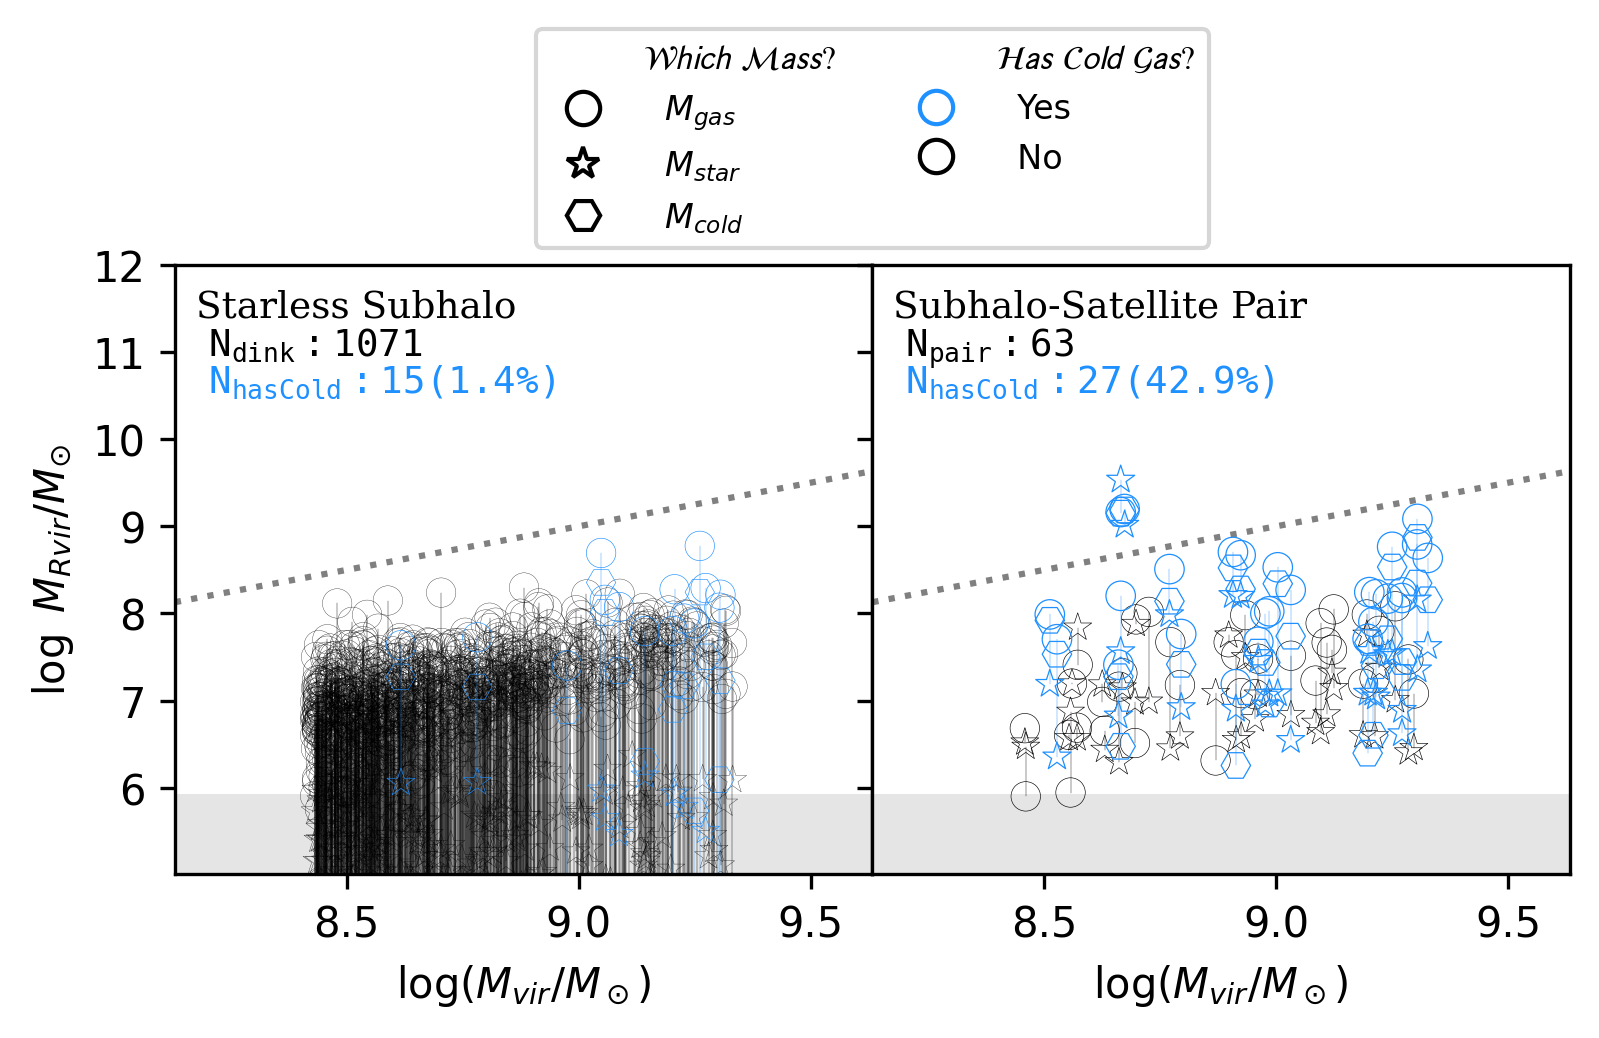

In [13]:
rname='Rvir'; mass_name='mvir'; xlabel='log($M_{vir}/M_\odot$)'
mass_suffix = "" if(mass_name=='mdm') else "_vir"
jump = False
if(not os.path.exists(f"03_components.png"))or(not jump):
    fig, axes = plt.subplots(ncols=2, dpi=300, figsize=(6,8), sharey=True)

    samples = [dinks1, pairs1, upairs1]
    samples2 = [dinks2, pairs2, upairs2]
    names = ["dink", "pair"]
    titles = ["Starless Subhalo", "Subhalo-Satellite Pair"]
    for i in range(2):
        ax = axes[i]
        sample = np.hstack((samples[i], samples2[i]))
        sample = sample[(sample['mvir']>=m1)&(sample['mvir']<=m2)]
        mask = sample[f'mcold{mass_suffix}'] < 1e3; sample[f'mcold{mass_suffix}'][mask] = 1e3
        mask = sample[f'mstar{mass_suffix}'] < 1e3; sample[f'mstar{mass_suffix}'][mask] = 1e3
        hascolds = sample[f'mcold{mass_suffix}']>1e3
        for iarr in tqdm(sample):
            hascold = iarr[f'mcold{mass_suffix}']>1e3
            color = 'k' if(not hascold) else 'dodgerblue'
            lw = 0.15 if(not hascold) else 0.3
            zorder = 0 if(not hascold) else 1
            facecolor='none'# if(isdink) else color
            edgecolor=color# if(isdink) else 'none' 
            linecolor=color
            if(i==0): lw/=2
            

            ax.scatter(np.log10(iarr[mass_name]), np.log10(iarr[f'mstar{mass_suffix}']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=lw, marker='*', zorder=zorder)
            if(iarr[f'mcold{mass_suffix}']>1e3): ax.scatter(np.log10(iarr[mass_name]), np.log10(iarr[f'mcold{mass_suffix}']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=lw, marker='H', zorder=zorder)
            ax.scatter(np.log10(iarr[mass_name]), np.log10(iarr[f'mcell{mass_suffix}']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=lw, zorder=zorder)
            vmax = np.max([np.log10(iarr[f'mstar{mass_suffix}']), np.log10(iarr[f'mcell{mass_suffix}']), np.log10(iarr[f'mcold{mass_suffix}'])])
            if(iarr[f'mcold{mass_suffix}']>1e3): 
                vmin = max( np.min([np.log10(iarr[f'mstar{mass_suffix}']), np.log10(iarr[f'mcell{mass_suffix}']), np.log10(iarr[f'mcold{mass_suffix}'])]), 3 )
            else:
                vmin = max( np.min([np.log10(iarr[f'mstar{mass_suffix}']), np.log10(iarr[f'mcell{mass_suffix}'])]), 3 )
            ax.plot([np.log10(iarr[mass_name]),np.log10(iarr[mass_name])], [vmin, vmax], color=linecolor, lw=0.1, zorder=zorder)

        ax.text(0.03, 0.96, f"{titles[i]}", ha='left', va='top', color='k', fontsize=9, transform=ax.transAxes, family='serif')
        ax.text(0.03, 0.90, fr"$\mathtt{{ \ N_{{{names[i]}}}: {len(sample)} }}$", ha='left', va='top', color='k', fontsize=9, transform=ax.transAxes)
        ax.text(0.03, 0.84, fr"$\mathtt{{ \ N_{{hasCold}}: {np.sum(hascolds)}({np.sum(hascolds)/len(sample)*100:.1f}\%) }}$", ha='left', va='top', color='dodgerblue', fontsize=9, transform=ax.transAxes)

    icol = 0
    for ax in axes.flatten():
        ax.fill_between([7.9,12.1],3, np.log10(np.min(gals1['m'])), ec='none', fc='grey', alpha=0.2, zorder=-1)

        ax.set_xlim(np.log10(m1/2),np.log10(m2*2))
        xlim = ax.get_xlim()
        ax.plot(xlim, xlim, ls=':', color='grey', zorder=-1)
        ax.set_ylim(5.01,12)
        if(icol==0): ax.set_ylabel(fr"$\log\ M_{{{rname}}}/M_{{\odot}}$")
        ax.set_xlabel(xlabel)
        icol += 1


    # Making Legend
    from matplotlib.lines import Line2D
    axes[0].set_aspect(np.log10(m2*4/m1)/4/2)
    axes[1].set_aspect(np.log10(m2*4/m1)/4/2)
    legend_elements = [
        Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label=r'$\mathcal{Which\ Mass?}$'),
        Line2D([0],[0], marker='o',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{gas}$'),
        Line2D([0],[0], marker='*',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{star}$'),
        Line2D([0],[0], marker='H',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{cold}$'),
        Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label=r'$\mathcal{Has\ Cold\ Gas?}$'),
        Line2D([0],[0], marker='o',color='none', markerfacecolor='none', markeredgecolor='dodgerblue', markersize=8, label='  Yes'),
        Line2D([0],[0], marker='o',color='none', markerfacecolor='none', markeredgecolor='k', markersize=8, label='  No'),
    ]

    plt.subplots_adjust(hspace=0, wspace=0)
    axes[1].legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0, 1), fontsize=8, ncols=2)

    # plt.savefig(f"03_components_comp.png", dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
    plt.show(); plt.close()

In [17]:
LGmask1 = isin(allsubs1['Host'], keys1)
LGmask1.all()

True

In [18]:
def draw_analysis(yvalue, fname, yerrs=None,ymask=None, xname='mvir', ylabel='value', legkwargs={}, ylim=None, logscale=False):
    global allsubs1, states1, dinks1, pairs1
    global allsubs2, states2, dinks2, pairs2

    allsubs = np.hstack((allsubs1,allsubs2))
    states = np.hstack((states1,states2))
    dinks = np.hstack((dinks1, dinks2))
    pairs = np.hstack((pairs1, pairs2))
    m1d, m2d = np.nanpercentile(dinks[xname], q=[2.5,97.5])
    m1p, m2p = np.nanpercentile(pairs[xname], q=[2.5,97.5])
    m1 = np.max([m1d,m1p]); m2 = np.min([m2d,m2p])

    mbins = np.linspace(7,12,9)
    mleng = len(mbins)-1
    xs = 0.5*(mbins[1:]+mbins[:-1])
    colors = ['k', 'r', 'b', 'g']
    

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8), dpi=150, sharey='row', sharex='col', gridspec_kw={'width_ratios': [4, 1], 'height_ratios': [1, 4]})
    AX = axes[1,0]
    if(logscale): AX.set_yscale('log')
    ax_right = axes[1,1]
    ax_top = axes[0,0]
    ax_top.set_ylabel("Normed Den.")

    # Dink
    # -------------------------------------------------------------------------
    color='tomato'
    mask = states=='dink'
    if(ymask is not None): mask = mask & ymask
    if(len(yvalue) != len(allsubs)):
        sample = allsubs[mask]
        val = yvalue[mask]
        if(yerrs is not None): err = yerrs[mask]
    else:
        sample = allsubs[mask]
        val = yvalue[mask]
        if(yerrs is not None): err = yerrs[mask]

    if(yerrs is None): AX.scatter(np.log10(sample[xname]), val, s=5, ec=color,fc='none', label='Starless', marker='s')
    else: AX.errorbar(np.log10(sample[xname]), val, yerr=err, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='Starless')
    colorcount=1
    ys = np.zeros(mleng)-1; y16s = np.zeros(mleng)-1; y84s = np.zeros(mleng)-1
    for i in range(mleng):
        mask = (sample[xname] >= 10**mbins[i])&(sample[xname] < 10**mbins[i+1])
        if(np.sum(mask)>3):
            value = val[mask]
            y16s[i], ys[i], y84s[i] = np.nanpercentile(value, q=[16,50,84])
        else:
            y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
    mask = ~np.isnan(ys)
    AX.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[colorcount], ec='none', alpha=0.2, zorder=5)
    AX.plot(xs[mask], ys[mask], color=colors[colorcount], zorder=6)
    colorcount+=1
    complete = (sample[xname] >= m1)&(sample[xname] <= m2)
    y0=np.nanmin(val[complete]); y1=np.nanmax(val[complete])
    if(ylim is not None): y0=ylim[0]; y1=ylim[1]
    if(logscale): y0=np.log10(y0); y1=np.log10(y1)
    bins = np.linspace(y0, y1, 20)
    if(logscale): bins = np.logspace(y0, y1, 20)
    ax_right.hist(val[complete], bins=bins, orientation='horizontal', color=color, histtype='step', density=True)
    q16,q50,q84 = np.nanpercentile(val[complete], q=[16,50,84])
    ax_right.axhline(q50, color=colors[1], label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
    ax_right.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
    ax_top.hist(np.log10(sample[xname]), bins=20, color=color, histtype='step', density=True)

    # Pair
    # -------------------------------------------------------------------------
    color='dodgerblue'
    mask = states=='pair'
    if(ymask is not None): mask = mask & ymask
    if(len(yvalue) != len(allsubs)):
        sample = allsubs[mask]
        val = yvalue[mask]
        if(yerrs is not None): err = yerrs[mask]
    else:
        sample = allsubs[mask]
        val = yvalue[mask]
        if(yerrs is not None): err = yerrs[mask]

    if(yerrs is None): AX.scatter(np.log10(sample[xname]), val, s=5, ec=color,fc='none', label='Pair', marker='s')
    else: AX.errorbar(np.log10(sample[xname]), val, yerr=err, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='Pair')
    ys = np.zeros(mleng)-1; y16s = np.zeros(mleng)-1; y84s = np.zeros(mleng)-1
    for i in range(mleng):
        mask = (sample[xname] >= 10**mbins[i])&(sample[xname] < 10**mbins[i+1])
        if(np.sum(mask)>3):
            value = val[mask]
            y16s[i], ys[i], y84s[i] = np.nanpercentile(value, q=[16,50,84])
        else:
            y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
    mask = ~np.isnan(ys)
    AX.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[colorcount], ec='none', alpha=0.2, zorder=5)
    AX.plot(xs[mask], ys[mask], color=colors[colorcount], zorder=6)
    colorcount+=1
    complete = (sample[xname] >= m1)&(sample[xname] <= m2)
    bins = np.linspace(np.nanmin(val[complete]), np.nanmax(val[complete]), 20)
    if(logscale): bins = np.logspace(np.nanmin(np.log10(val[complete])), np.nanmax(np.log10(val[complete])), 20)
    ax_right.hist(val[complete], bins=bins, orientation='horizontal', color=color, histtype='step', density=True)
    q16,q50,q84 = np.nanpercentile(val[complete], q=[16,50,84])
    ax_right.axhline(q50, color=colors[2], label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
    ax_right.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
    ax_top.hist(np.log10(sample[xname]), bins=20, color=color, histtype='step', density=True)


    AX.legend()
    ax_right.legend(**legkwargs)

    AX.axvspan(np.log10(m1), np.log10(m2), ec='none', fc='gainsboro', zorder=-1)
    ax_top.axvspan(np.log10(m1), np.log10(m2), ec='none', fc='gainsboro', zorder=-1)
    ax_right.set_facecolor('gainsboro')
    ax_top.text((np.log10(m1)+np.log10(m2))/2, ax_top.get_ylim()[1]*0.9, '"Complete"\nrange', ha='center', va='top', color='k', fontsize=8, family='serif')
    if(xname=='mvir'): AX.set_xlabel(r'logM$_{\rm vir}$ [M$_\odot$]')
    elif(xname=='mdm_vir'): AX.set_xlabel(r'logM$_{\rm DM,vir}$ [M$_\odot$]')
    AX.set_ylabel(ylabel)
    ax_right.set_xlabel(r'Normed Den.')
    ax_right.set_xlim(0.001,)
    if(ylim is not None): AX.set_ylim(*ylim)
    plt.subplots_adjust(wspace=0, hspace=0)
    # plt.savefig(fname, dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
    plt.show(); plt.close()

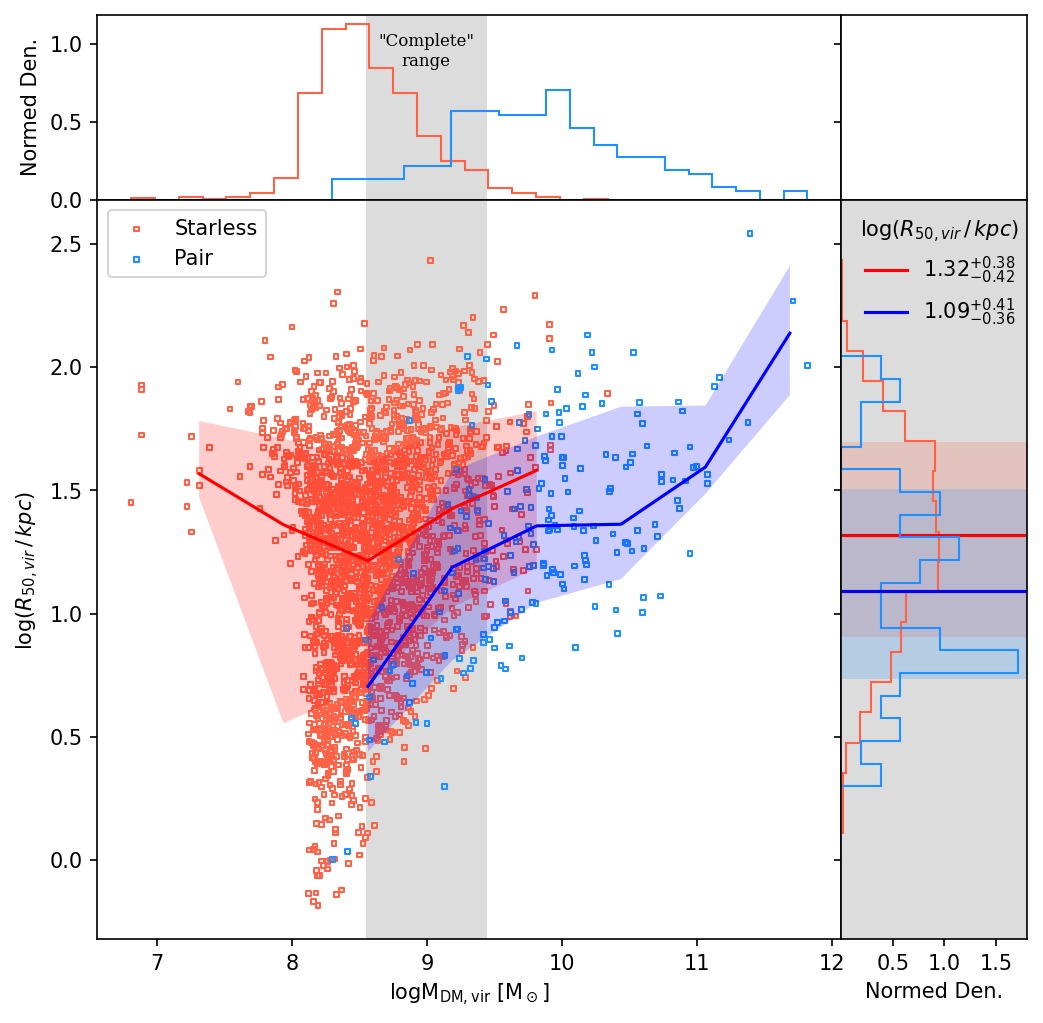

In [20]:
yvalue = np.hstack(( np.log10( allsubs1['r50_vir']/snap1.unit['kpc'] ), np.log10( allsubs2['r50_vir']/snap2.unit['kpc'] ) ))
fname = f"03_sizemass.png"
ylabel = r'log$(R_{50,vir}\,/\,kpc)$ '
legtitle = r'log$(R_{50,vir}\,/\,kpc)$ '
legkwargs = dict(title=legtitle, frameon=False)
draw_analysis(yvalue, fname, xname='mdm_vir', ylabel=ylabel, legkwargs=legkwargs)

/tmp/ipykernel_20031/1325373136.py:11: RuntimeWarning: divide by zero encountered in log10
  yvalue = np.log10(yvalue)


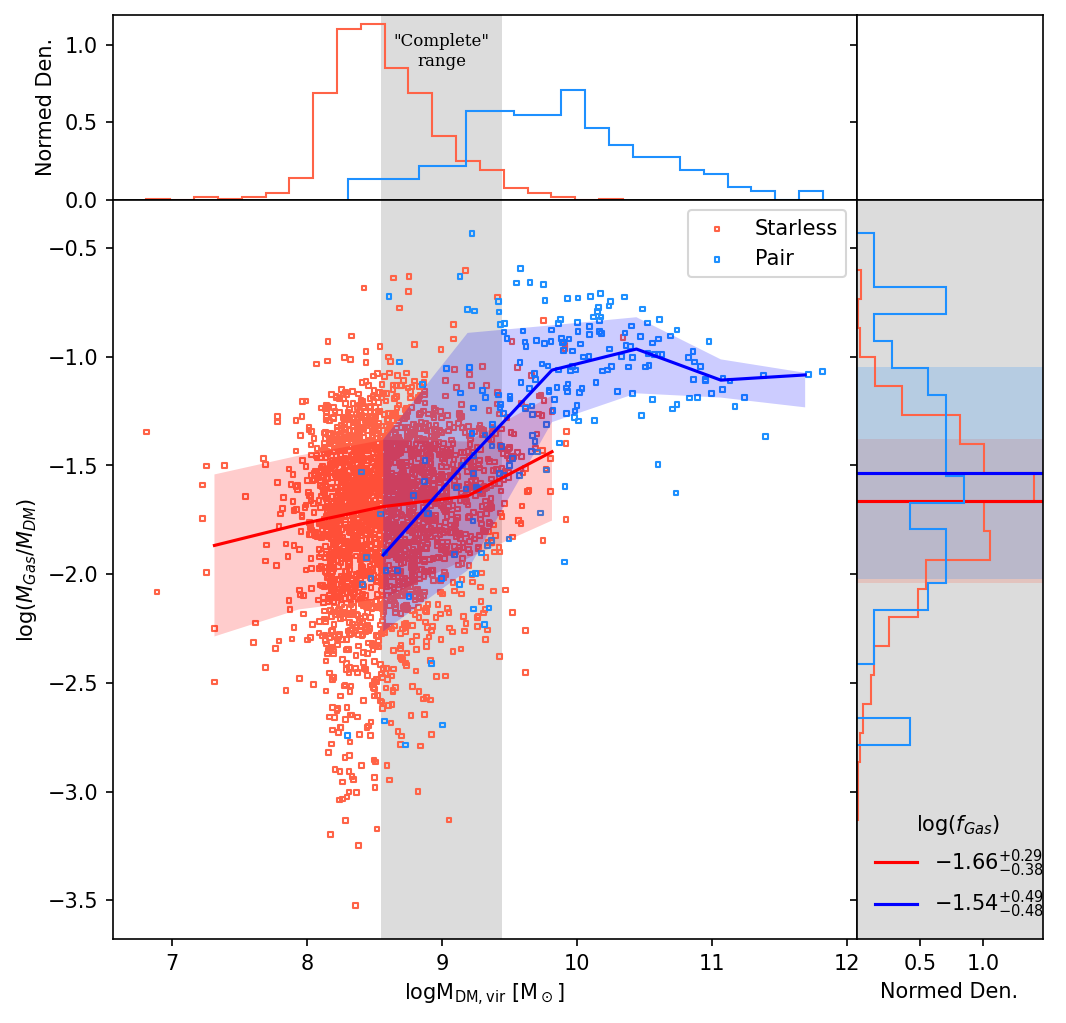

In [21]:
ylabel = r'log$(M_{Gas}/M_{DM})$ '
legtitle = r'log$(f_{Gas})$ '
legkwargs = dict(title=legtitle, frameon=False)
ylim = None

sample = np.hstack((allsubs1,allsubs2 ))
yvalue = sample['mcell_vir'] / (sample['mdm_vir']+sample['mstar_vir']+sample['mcell_vir'])
ymask = yvalue>0
# yvalue[yvalue==0] = 10**(-6.5)
# ymask = None
yvalue = np.log10(yvalue)
fname = f"04_fcell.png"
draw_analysis(yvalue, fname, ymask=ymask, xname='mdm_vir', ylabel=ylabel, legkwargs=legkwargs, ylim=ylim)

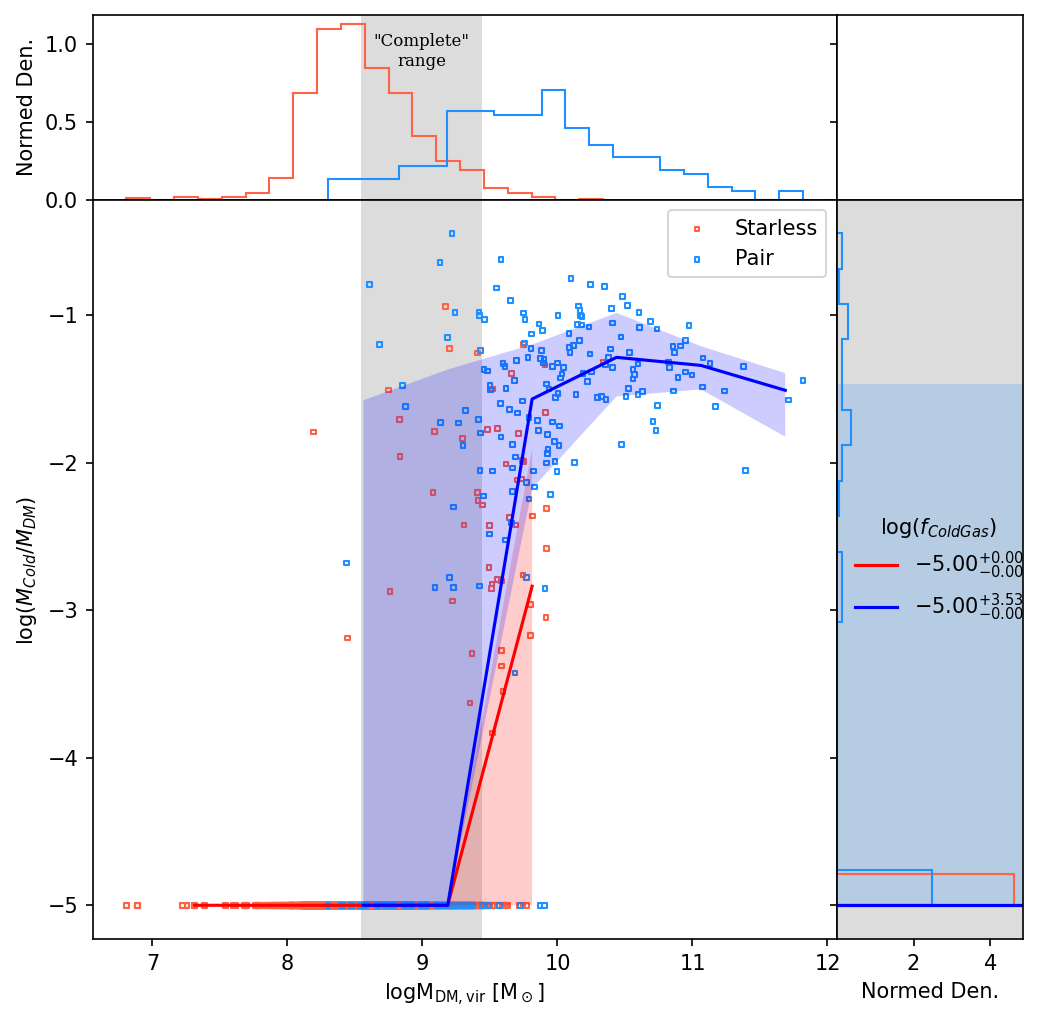

In [22]:
ylabel = r'log$(M_{Cold}/M_{DM})$ '
legtitle = r'log$(f_{ColdGas})$ '
legkwargs = dict(title=legtitle, frameon=False)
ylim = None

sample = np.hstack((allsubs1,allsubs2 ))
yvalue = sample['mcold_vir'] / (sample['mdm_vir']+sample['mstar_vir']+sample['mcell_vir'])
yvalue[yvalue==0] = 10**(-5)
# ymask = yvalue>0
# yvalue[yvalue==0] = 10**(-6.5)
ymask = None
yvalue = np.log10(yvalue)
fname = f"04_fcold.png"
draw_analysis(yvalue, fname, ymask=ymask, xname='mdm_vir', ylabel=ylabel, legkwargs=legkwargs, ylim=ylim)